In [1]:
import rom_inverse as ri
import torch
import matplotlib.pyplot as plt

In [2]:
permeability_random_field = ri.DiscretizedRandomField()

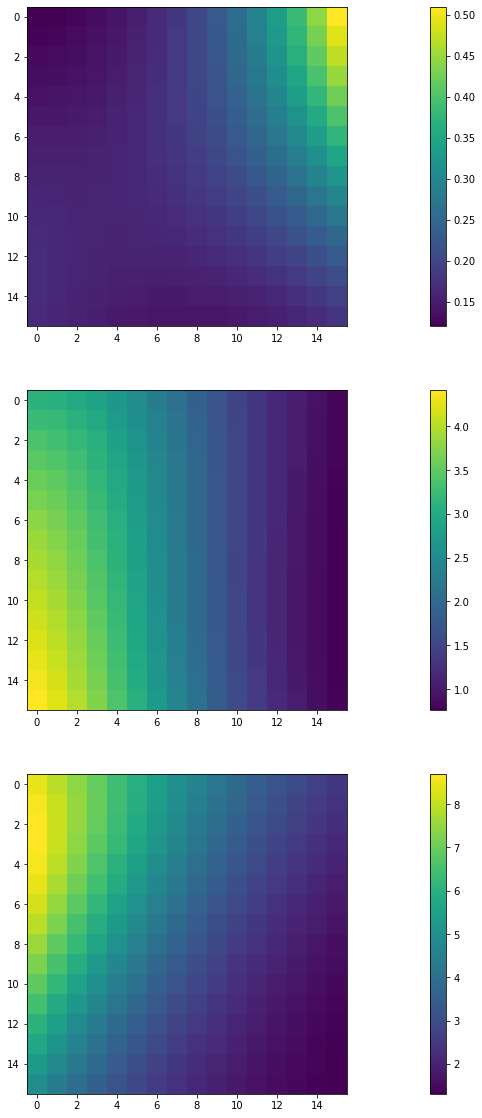

In [3]:
permeability_random_field.plot_realizations()